In [1]:
import glob
import os
import string

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix

### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames. 

We will restrict to some common European languages. 

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation. 

Foresee a suitable character for the end of the word, e.g. 'END'.

In [2]:
srcdir = 'data/names'
languages = ["English","French","Italian","German","Spanish"]

In [3]:
# inspect the data directory
def findFiles(path): 
    return glob.glob(path)

In [4]:
print('\n'.join(findFiles(os.path.join(srcdir,'*.txt'))))

data/names/French.txt
data/names/Dutch.txt
data/names/Greek.txt
data/names/Japanese.txt
data/names/Chinese.txt
data/names/Scottish.txt
data/names/Italian.txt
data/names/Polish.txt
data/names/Portuguese.txt
data/names/Russian.txt
data/names/Vietnamese.txt
data/names/Irish.txt
data/names/Czech.txt
data/names/Korean.txt
data/names/German.txt
data/names/English.txt
data/names/Arabic.txt
data/names/Spanish.txt


In [5]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir,'*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories: 
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df

In [6]:
names = load_data(srcdir,categories=languages)
names.head()

,name,lang
0,Abel,French
1,Abraham,French
2,Adam,French
3,Albert,French
4,Allard,French


In [7]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)

Maximum name length:  18


In [8]:
alphabet = sorted(list(set(''.join([name for name in names.name]))))
alphabet.append('END')
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ",len_alphabet)
print(alphabet)

Size of alphabet:  74
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END']


<Axes: xlabel='lang'>

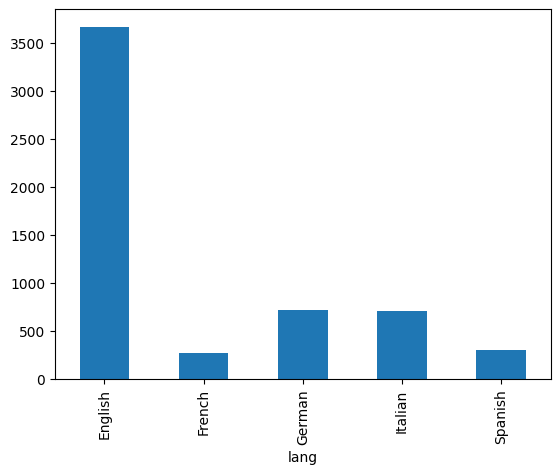

In [9]:
names.groupby('lang')['name'].count().plot.bar()

In [10]:
names.shape

(5676, 2)

### Vector Representations

Now construct the vector representation by using one-hot-vectors. 

In [11]:
language_to_index = {country:index for index,country in enumerate(names.lang.unique())}
index_to_language = {index:country for index,country in enumerate(names.lang.unique())}

In [12]:
def onehot(i, length):
    """
    Generates a one-hot encoded vector.

    Parameters:
    i (int): The index to be encoded as 1.
    length (int): The total length of the output vector.

    Returns:
    numpy.ndarray: A one-hot encoded vector of the specified length, where the ith position is 1, and all other positions are 0.
    """
    v = np.zeros(length)
    v[i] = 1
    return v

def name_representation(name, maxlen, char_index):
    """
    Converts a given name to a list of one-hot encoded vectors representing each character.

    Parameters:
    name (str): The name to be encoded.
    maxlen (int): The maximum length for the name encoding. The encoding is padded or truncated to this length.

    Returns:
    list of numpy.ndarray: A list of one-hot encoded vectors for each character in the name. 
    If the name is shorter than `maxlen`, the remaining slots are filled with the "END" character.
    """
    name_trunc = str(name)[:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[char], size) for char in name_trunc]
    for _ in range(maxlen - len(name_trunc)):
        vector.append(onehot(char_index['END'], size))
    return np.array(vector)

def lang_representation(language, language_to_index):
    """
    Generates a one-hot encoded vector representing the language of a name.

    Parameters:
    language (str): The language to be encoded.
    language_to_index (dict): A mapping of languages to their corresponding indices.

    Returns:
    numpy.ndarray: A one-hot encoded vector indicating the language.
    """
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]] = 1
    return y

def lang_from_output(score):
    """
    Converts a predicted score vector to the corresponding language label.

    Parameters:
    score (numpy.ndarray): The predicted score vector.

    Returns:
    str: The language corresponding to the maximum score.
    """
    return index_to_language[np.argmax(score)]

def predict(name, model):
    """
    Predicts the language of a given name using a trained model.

    Parameters:
    name (str): The name for which to predict the language.
    model (keras.Model): The trained model used for prediction.

    Returns:
    str: The predicted language of the name.
    """
    score = model.predict(name_representation(name, maxlen, char_index))[0]
    return lang_from_output(score)


### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the names data into a suitable vector respresentation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [13]:
test_split = 0.2

### START YOUR CODE

# Drop duplicates (Sommer) is 4 times for instance
names.drop_duplicates(subset=['name','lang'],inplace=True)

# Shuffle and split names data

train = names.sample(frac=0.8, random_state=42)
test = names.drop(train.index)

### END YOUR CODE

In [14]:
# tnc = train['name'] + '|' + train['lang']
# ttc = test['name'] + '|' + test['lang']

# tn = set(tnc)
# tt = set(ttc)

# tn.intersection(tt)

In [15]:
### START YOUR CODE

# Map train and test data into vector space (one-hot-vectors)

X_train = np.stack(train.apply(lambda row: name_representation(row['name'], maxlen, char_index), axis=1).to_numpy())
Y_train = np.stack(train.apply(lambda row: lang_representation(row['lang'], language_to_index), axis=1).to_numpy())

X_test = np.stack(test.apply(lambda row: name_representation(row['name'], maxlen, char_index), axis=1).to_numpy())
Y_test = np.stack(test.apply(lambda row: lang_representation(row['lang'], language_to_index), axis=1).to_numpy())

# X_train = np.array([name_representation(name, maxlen) for name in train['name']])
# Y_train = np.array([lang_representation(lang, language_to_index) for lang in train['lang']])

# X_test = np.array([name_representation(name, maxlen) for name in test['name']])
# Y_test = np.array([lang_representation(lang, language_to_index) for lang in test['lang']])

### END YOUR CODE

### Utilities

In [16]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [17]:
import sklearn
import pandas as pd

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    nsamples = Y_test.shape[0]
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({languages[i] : cm[:,i] for i in range(len(languages))}, languages)
    return df, cm

### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [18]:
### START YOUR CODE

# SImpleRNN, single layer with tf.keras....
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(maxlen,len_alphabet)))
model.add(Dense(len(languages), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


### END YOUR CODE

2024-05-11 09:04:48.611294: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 09:04:49.247846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-11 09:04:49.688008: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-11 09:04:49.711215: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Fo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,221 (36.02 KB)

 Trainable params: 9,221 (36.02 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
### START YOUR CODE
batch_size= 24
nepochs = 20

log1 = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=nepochs, 
    validation_data=(X_test, Y_test)
)

### END YOUR CODE

Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6046 - loss: 1.1508 - val_accuracy: 0.7290 - val_loss: 0.8277
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7064 - loss: 0.8598 - val_accuracy: 0.7511 - val_loss: 0.7286
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7315 - loss: 0.7734 - val_accuracy: 0.7839 - val_loss: 0.6370
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7379 - loss: 0.7388 - val_accuracy: 0.7644 - val_loss: 0.6610
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7527 - loss: 0.6886 - val_accuracy: 0.7458 - val_loss: 0.6891
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7542 - loss: 0.6673 - val_accuracy: 0.7688 - val_loss: 0.6274
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7662 - loss: 0.6400 - val_accuracy: 0.7927 - val_loss: 0.6018
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7851 - loss: 0.5914 - val_accuracy: 0.

In [20]:
# performance_plots(model, X_test, Y_test, log1, nepochs)
# df1, cm1 = confusion_matrix(model, X_test, Y_test)

### Handle Class Imbalance, Resampling

We can observe a quite significant class imbalance in the data.<br>

One way to compensate for that would be to use resampling.

In [21]:
def handle_imbalance(names, languages):
    """
    Treat class imbalance by manually oversampling minority classes.

    Parameters:
    names (DataFrame): A DataFrame containing columns 'name' and 'lang'.
    languages (list): A list of all languages to consider.

    Returns:
    DataFrame: An upsampled DataFrame with balanced class distribution.
    """
    # Find the largest class size
    max_size = names['lang'].value_counts().max()

    # Initialize an empty list to store upsampled data
    names_upsampled = []

    # Loop through each language and upsample it
    for lang in languages:
        # Filter the dataset to only contain names of the current language
        subset = names[names['lang'] == lang]

        # Upsample the subset to match the size of the largest class
        subset_upsampled = subset.sample(n=max_size, replace=True, random_state=42)

        # Add the upsampled subset to the final list
        names_upsampled.append(subset_upsampled)

    # Concatenate all upsampled subsets into a single DataFrame
    names_upsampled = pd.concat(names_upsampled)

    return names_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)


<Axes: xlabel='lang'>

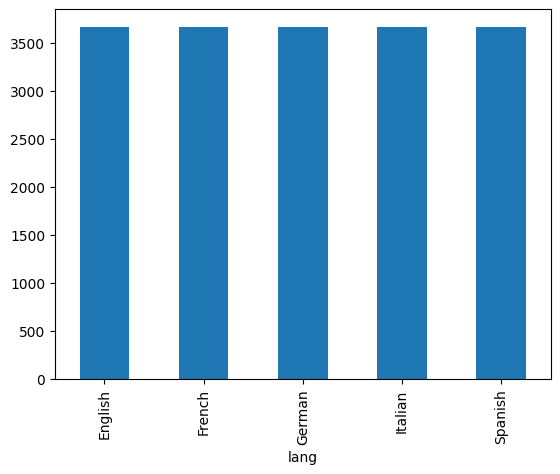

In [22]:
names_upsampled = handle_imbalance(names, languages)
names_upsampled.groupby('lang')['name'].count().plot.bar()

In [23]:
names_upsampled.shape

(18340, 2)

#### Train Model

Again prepare train and test data (X_train, X_test, Y_train, Y_test)

Train the same model as above with the new data.

In [24]:
### START YOUR CODE

train = names_upsampled.sample(frac=0.8, random_state=42)
test = names_upsampled.drop(train.index)

X_train = np.stack(train.apply(lambda row: name_representation(row['name'], maxlen, char_index), axis=1).to_numpy())
Y_train = np.stack(train.apply(lambda row: lang_representation(row['lang'], language_to_index), axis=1).to_numpy())

X_test = np.stack(test.apply(lambda row: name_representation(row['name'], maxlen, char_index), axis=1).to_numpy())
Y_test = np.stack(test.apply(lambda row: lang_representation(row['lang'], language_to_index), axis=1).to_numpy())

### END YOUR CODE

In [25]:
### START YOUR CODE

# train model
model2 = Sequential()
model2.add(SimpleRNN(units=64, input_shape=(maxlen,len_alphabet)))
model2.add(Dense(len(languages), activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

log2 = model2.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=nepochs,
    validation_data=(X_test, Y_test)
)
### END YOUR CODE

/home/olivier/anaconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         8,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,221 (36.02 KB)

 Trainable params: 9,221 (36.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4358 - loss: 1.3020 - val_accuracy: 0.6404 - val_loss: 0.9058
Epoch 2/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6647 - loss: 0.8640 - val_accuracy: 0.6966 - val_loss: 0.7833
Epoch 3/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7511 - loss: 0.6627 - val_accuracy: 0.7961 - val_loss: 0.5567
Epoch 4/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8180 - loss: 0.5005 - val_accuracy: 0.8296 - val_loss: 0.4788
Epoch 5/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8556 - loss: 0.4173 - val_accuracy: 0.8585 - val_loss: 0.4012
Epoch 6/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8724 - loss: 0.3566 - val_accuracy: 0.8678 - val_loss: 0.3753
Epoch 7/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8957 - loss: 0.3066 - val_accuracy: 0.8888 - val_loss: 0.3435
Epoch 8/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9040 - loss: 0.2799 - val_accuracy: 0.

In [26]:
# performance_plots(model2, X_test, Y_test, log2, nepochs)
# df2, cm2 = confusion_matrix(model2, X_test, Y_test)
# df2

#### Findings


The implementation of a multi-layer RNN generally provides improved modeling capabilities due to its ability to capture deeper patterns in sequential data. However, it also increases the risk of overfitting, especially on smaller datasets, and requires more computational resources. The performance plots and confusion matrices between the single-layer and multi-layer models will reveal if the additional complexity translates into better predictive performance.


#### In which situations is class imbalance treatment important and why?  

Class imbalance treatment is crucial in scenarios where predictive accuracy across multiple classes is essential. In datasets with unequal representation of classes, models tend to favor the majority class, leading to poor generalization on minority classes. Handling this ensures that the model performs well across all classes, which is particularly important in applications where the cost of misclassification is high for underrepresented classes.

### Implement Model with several SimpleRNN Layers

In [27]:
### START YOUR CODE

# Define a model with multiple SimpleRNN layers
model_multi_rnn = Sequential()
model_multi_rnn.add(SimpleRNN(units=64, input_shape=(maxlen, len_alphabet), return_sequences=True))
model_multi_rnn.add(SimpleRNN(units=32, return_sequences=False))
model_multi_rnn.add(Dense(len(languages), activation='softmax'))

model_multi_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_multi_rnn.summary()

# Train the model
log_multi_rnn = model_multi_rnn.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=nepochs,
    validation_data=(X_test, Y_test)
)

### END YOUR CODE

model_multi_rnn.summary()

/home/olivier/anaconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 18, 64)         │         8,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,165 (47.52 KB)

 Trainable params: 12,165 (47.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4515 - loss: 1.2885 - val_accuracy: 0.6660 - val_loss: 0.8502
Epoch 2/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6895 - loss: 0.7939 - val_accuracy: 0.7426 - val_loss: 0.6774
Epoch 3/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7801 - loss: 0.5788 - val_accuracy: 0.8103 - val_loss: 0.5098
Epoch 4/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8319 - loss: 0.4615 - val_accuracy: 0.8345 - val_loss: 0.4522
Epoch 5/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8618 - loss: 0.3853 - val_accuracy: 0.8645 - val_loss: 0.3844
Epoch 6/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8812 - loss: 0.3393 - val_accuracy: 0.8710 - val_loss: 0.3459
Epoch 7/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9013 - loss: 0.2928 - val_accuracy: 0.9065 - val_loss: 0.2925
Epoch 8/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9082 - loss: 0.2649 - val_accuracy: 0.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 18, 64)         │         8,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,497 (142.57 KB)

 Trainable params: 12,165 (47.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,332 (95.05 KB)

In [28]:
# performance_plots(model_multi_rnn, X_test, Y_test, log_multi_rnn, nepochs)
# df3, cm3 = confusion_matrix(model_multi_rnn, X_test, Y_test)
# df3

#### Findings


Train accuracy (end): 0.8702104091644287
Train accuracy (max): 0.8702104091644287
Test accuracy (end) : 0.7705934643745422
Test accuracy (max) : 0.7927369475364685


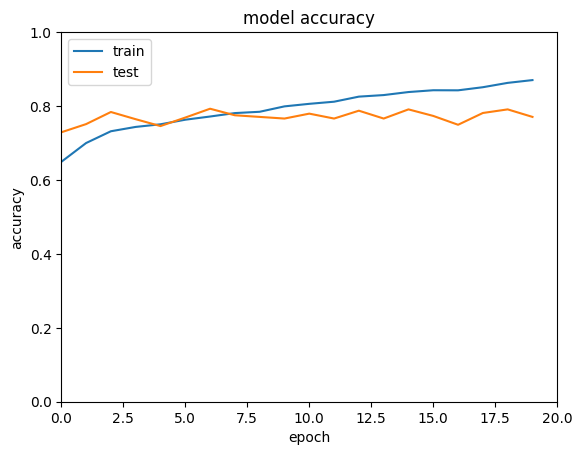

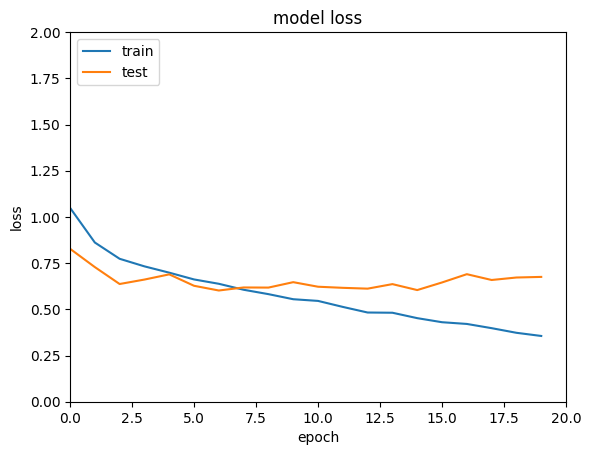

In [29]:
performance_plots(model, X_test, Y_test, log1, nepochs)

Train accuracy (end): 0.9474509358406067
Train accuracy (max): 0.9474509358406067
Test accuracy (end) : 0.9255725145339966
Test accuracy (max) : 0.9255725145339966


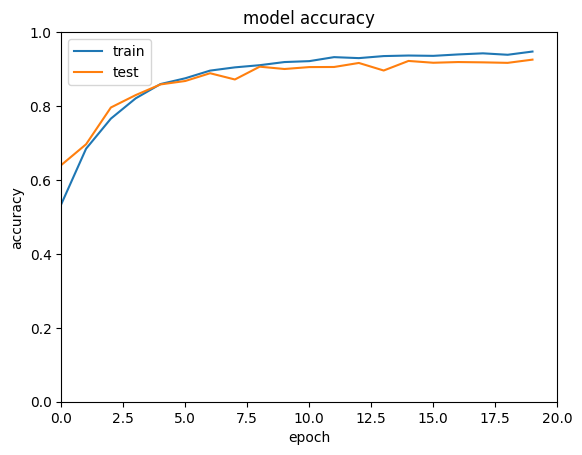

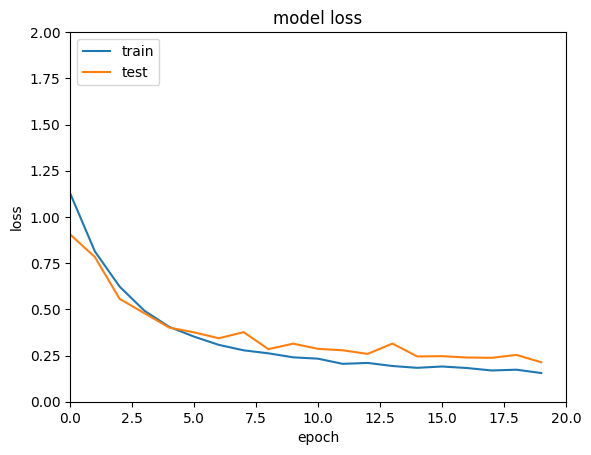

In [30]:
performance_plots(model2, X_test, Y_test, log2, nepochs)

Train accuracy (end): 0.9359323978424072
Train accuracy (max): 0.9415212869644165
Test accuracy (end) : 0.919847309589386
Test accuracy (max) : 0.925299882888794


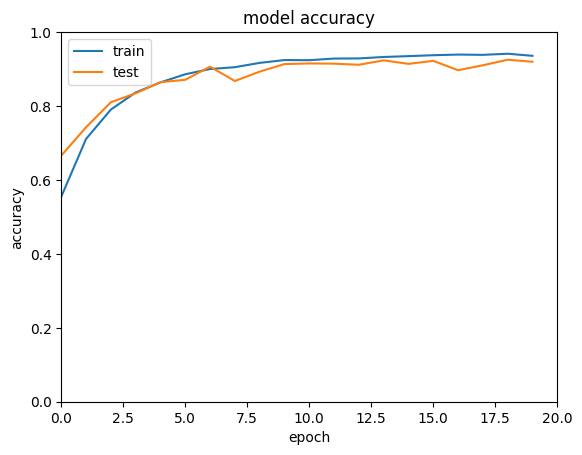

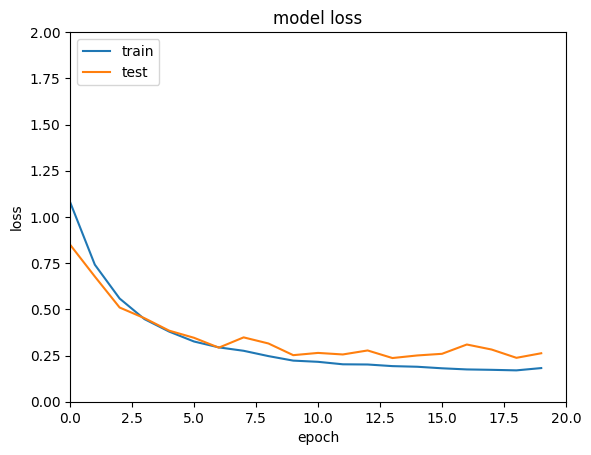

In [31]:
performance_plots(model_multi_rnn, X_test, Y_test, log_multi_rnn, nepochs)

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Text(0.5, 1.0, 'Multi-layer SimpleRNN')

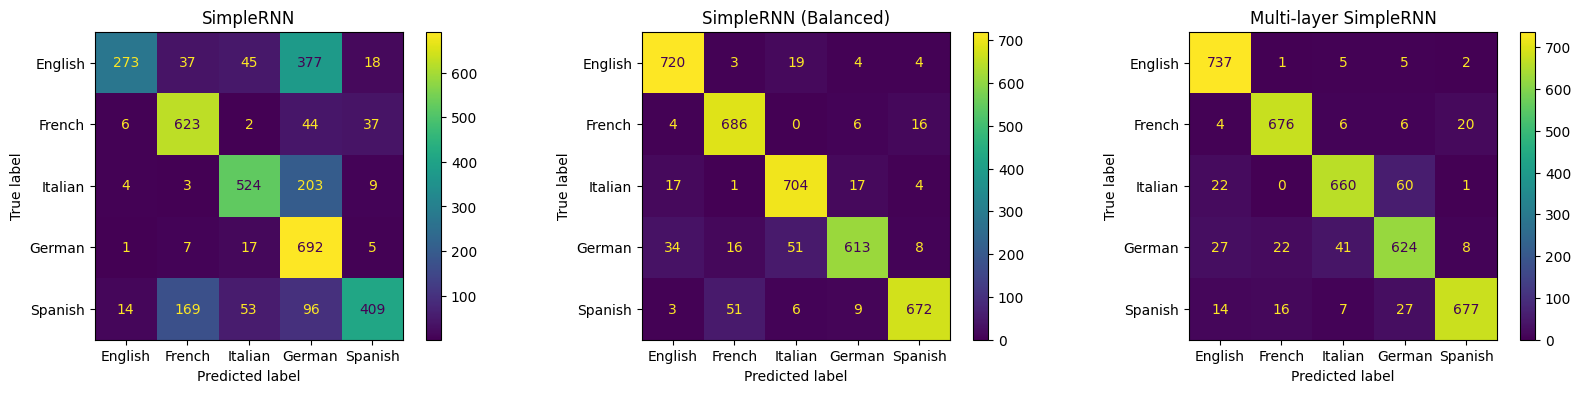

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay    

df1, cm1 = confusion_matrix(model, X_test, Y_test)
df2, cm2 = confusion_matrix(model2, X_test, Y_test)
df3, cm3 = confusion_matrix(model_multi_rnn, X_test, Y_test)

fig, axs = plt.subplots(1, 3, figsize=(20, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=languages)
disp.plot(ax=axs[0])
disp.ax_.set_title('SimpleRNN')
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=languages)
disp.plot(ax=axs[1])
disp.ax_.set_title('SimpleRNN (Balanced)')
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=languages)
disp.plot(ax=axs[2])
disp.ax_.set_title('Multi-layer SimpleRNN')

Our finding is that the first model is prone to overfitting because the class imbalance is not addressed. Thus, the model is biased towards the majority class as we can see from the confusion matrix. The German names are mixed with English 377 times. The second model, which uses resampling to address the class imbalance, shows improved performance in terms of accuracy and confusion matrix. The third model, which uses multiple SimpleRNN layers, performs as good as the second model, but with more complexity. Finally, we can conclude that in our case, class imbalance treatment is more important than increasing model complexity.